# Courier Churn: Modelling Exercise

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import ParameterSampler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve

%matplotlib inline

## Split df into target and feature (y,X)

In [18]:
df_pred= pd.read_csv('data_for_prediction.csv', index_col='courier')

In [19]:
X = df_pred.drop(['has_churned_mean'], axis=1)
y = df_pred['has_churned_mean']

## Models to compare Random Forest, GBM, Logistic Regression
In this step, I will train three different models suited for a classification task (Logistic Regression, Random Forest (RF), Gradient Boosting Machines (GBM)).
<br>

I choose these models since the way how predections are made is different for each one. As the name already gives away Logistic Regression (GLM) uses a regression approach where we model the probability of each class and this can be expressed in a linear way. Random Forest and GBM are both tree models and are non-parametric models which do not impose any functional form. The main difference between RF and GBM is the way how the models are fitted. A GBM model is an additive model where trees are build in a consecutive way improving the shortcomings of the previous ones. RF in comparison are build independtly form each other and are later combined by some rule (majority vote, average). 

## Split data into Test and Training

In [25]:
# Split data into train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## Set up parameter grids for gridsearch and model instances
Here I define the parameters for the hyperparamters tuning done in the next step, define the model instances and create a mapping dict for the model and hyperparameters:
- Logistic regression: C (Regularization Strength) and which regularization should be used
- RF: Number of Trees, Number of features at each split, Max Depth of each tree
- GBM: Learning Rate for the gradient descent, Max Depth of the each Tree, Number of Tress



In [26]:
grid_logistic = {"C":np.arange(0.5,2,0.05), "penalty":["l1","l2"]}
grid_rf = {'n_estimators': range(80,120,20)
           , 'max_features': ['auto', 'sqrt', 'log2']
           , 'max_depth' : range(6,12)}
grid_gbm = { 'learning_rate' : np.arange(0.01, 0.2, 0.05)
            , 'max_depth' : range(2,6)
            , 'n_estimators' : range(150,210,20)}

logit=LogisticRegression(solver='liblinear')
rf = RandomForestClassifier()
gbm = GradientBoostingClassifier()

model_grid_mapping={logit:grid_logistic, rf:grid_rf, gbm:grid_gbm}

## Grid Search with CV
As mentioned above I perform a grid search in order to find the best hyperparameters for each classifier. This is combined with a 10 fold cross validation in order to receive robust results

In [27]:
def model_selection(model_grid_dict, X_train, y_train, scoring, cv, verbose=True):
    """
    Perform a complete grid search for each model provided in the dict. based on parameter grid
    Returns two dicts. First dict is including all models and their scores/parameters.
    Second dict, best model with opt. paramters based on grid search
    
    IN:
    model_grid_dict (dict): key=model, value=paramter_grid
    X_train (df): Features for training
    y_train (df): Target variable
    scoring (str): evaluation metric
    cv: Number of k-fold cross validation
    verbose (bool): if True, prints best performing model
    
    OUT:
    best_model (tuple): ('Model Name', 'best_parameters')
    model_performance_list (list): list including all models, their best scores, and best_parameters
    """
    
    model_performance_list = []
    for model, grid in model_grid_dict.items():
        model_name = str(model).split("(")[0]
        print("Estimating: ", model_name)
        model_cv = GridSearchCV(model, grid, scoring=scoring ,cv=cv, n_jobs=2)
        model_cv.fit(X_train,y_train)
        best_score = model_cv.best_score_
        best_paramters = model_cv.best_params_
        model_performance_list.append((model_name, best_paramters, best_score))
        
    best_score = max([x[2] for x in model_performance_list])
    best_model = [x[:2] for x in model_performance_list if x[2] == best_score][0]    
    
    if verbose==True:
        print("*************************")
        print("Best performing model is: ", best_model[0])
        print("Best paramters: ", best_model[1])
        print("*************************")
        
    return best_model, model_performance_list
            

Remark: Please note that this is not a full GridSearc. We could explore with more hyperparameters for each classifier and further narrow those down using a random grid search in first. I would be more than happy to discuss this further of course.

In [29]:
best_model, model_performances = model_selection(model_grid_dict=model_grid_mapping
                                             , X_train=X_train
                                             , y_train=y_train
                                             , scoring='roc_auc', cv=10)

Estimating:  LogisticRegression
Estimating:  RandomForestClassifier
Estimating:  GradientBoostingClassifier
*************************
Best performing model is:  GradientBoostingClassifier
Best paramters:  {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 170}
*************************


## Results Model Selection
As printed above we see that the GBM classifier performed the best measured in Test-AUC. I will use the GBM model with it's best parameters resulting from the grid search as the final model in order to predict which couriers will churn and which will not.

(All models with the respective best Test-AUC scores and best hyperparameters are stored in model_performances if further inspection is desired)

## Evaluation of Final Model (GBM) against the test set

In [30]:
gbm = GradientBoostingClassifier(**best_model[1])

final_model = gbm.fit(X_train, y_train)

pred_final_model = final_model.predict(X_test)

eval_confusion_matrix = confusion_matrix(y_test, pred_final_model)
eval_classification_report = classification_report(y_test, pred_final_model)

print(eval_classification_report)

              precision    recall  f1-score   support

         0.0       0.75      0.84      0.79        73
         1.0       0.82      0.73      0.77        73

    accuracy                           0.78       146
   macro avg       0.78      0.78      0.78       146
weighted avg       0.78      0.78      0.78       146



We see that the final model is clearly better than random guessing. It achieves a accuracy of 78% meaning that it manages to predict the class of a courier (churn/non-churn) 78 times right out of a 100. Random guessing would only lead to a accuracy of 50% since the data is balanced. Furthermore, on this test split it manages to achieves a precision of 82% for couriers that churned meaning 82% of the times the model predicts churn the courier actually churned. On the other hand, for churners the model shows a recall of 73% meaning that it succesfully classifies 73% as churners out of all churners.  

## Feature importance
Lastly, I want to have a quick look which are the most influencial features. Interstingly, the features that show the highest relative importance are the ones as well identified in the EDA, namely feature 3,11, and the dummy for couriers that have churned during the training period. 

Text(0.5, 0, 'Relative Importance')

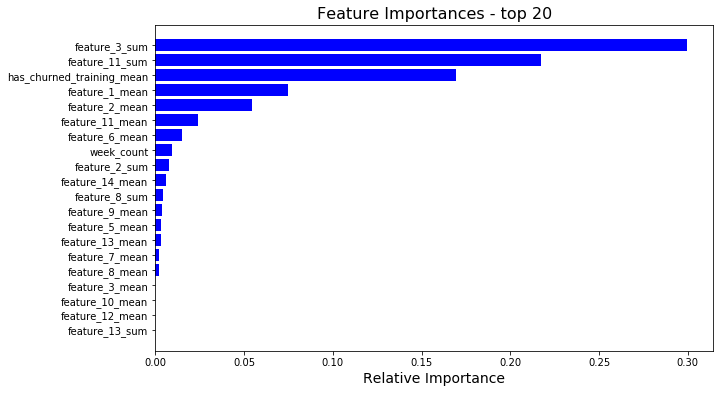

In [31]:
nr_features = 20
features=X_train.columns
importances = final_model.feature_importances_[:nr_features]
indices = np.argsort(importances)


plt.figure(figsize=(10,6))
plt.title(f"Feature Importances - top {nr_features}", fontsize=16)
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance', fontsize=14)

## Final Remarks

Going back to the start and the actual task at hand, the city manager now can make desicions driven by data. By doing so his planning security increased significantly. Without the churn prediction the manager was forced to treat each courier with a 50/50 chance as a churner. This means that he would need a fleet double the size that is actually needed to serve the orders since his error margin is 50%. With the model at hand, the manager desceases his error by 28 percentage points (Accuracy-model(78%) - Coin Flip/Random Guessing(50%)). Therefore, she/he only needs to cover for the remaining 22% of error. 

Numerical example:<br>

**Without Model:**<br>
Nr of available couriers in city: 1000<br>
Nr of couriers needed to serve orders: 500<br>
Propability of identifying courier correctly: 50%<br>
Needed fleed given probability: 1000 (500* (1/0.5))<br>

**With model:**<br>
Nr of available couriers in city: 1000<br>
Nr of couriers needed to serve orders: 500<br>
Propability of identifying courier correctly: 78%<br>
Needed fleed given probability: 641 (500* (1/0.78))<br>


# Appendix

## Comparison between GridSearch Models
For the sake of completeness I visually compare the model performance of the three models using the Precision-Recall curve and ROC Curve.

In [32]:
best_parameters_logit = model_performances[0][1]
best_parameters_rf = model_performances[1][1]

rf = RandomForestClassifier(**best_parameters_rf).fit(X_train, y_train)
rf_predictions = rf.predict_proba(X_test)[:, 1]

logit = LogisticRegression(solver='liblinear',**best_parameters_logit).fit(X_train, y_train)
logit_predictions = logit.predict_proba(X_test)[:, 1]

gbm_predictions = final_model.predict_proba(X_test)[:, 1]

## Precision Recall Curve

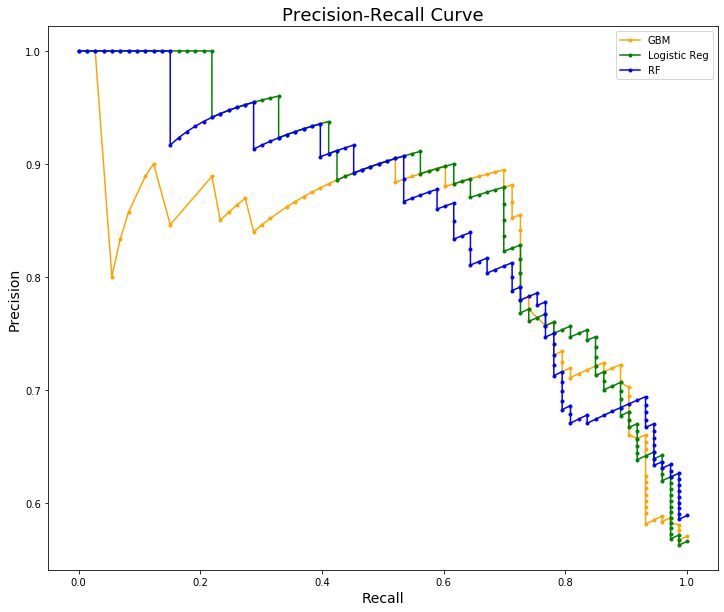

In [35]:

precision_gbm, recall_gbm, thresholds_gbm = precision_recall_curve(y_test, gbm_predictions)
precision_logistic, recall_logistic, thresholds_logistic = precision_recall_curve(y_test, logit_predictions)
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test, rf_predictions)


fig, ax = plt.subplots(figsize=(12,10))

ax.plot(recall_gbm, precision_gbm, marker='.', color='orange', label='GBM')
ax.plot(recall_logistic, precision_logistic, marker='.', color='green', label='Logistic Reg')
ax.plot(recall_rf, precision_rf, marker='.', color='blue', label='RF')

plt.title("Precision-Recall Curve", fontsize=18)
plt.ylabel("Precision", fontsize=14)
plt.xlabel("Recall", fontsize=14)
plt.legend()

Logistic Regression and GBM are very similar in the region of interest (balanced precision and recall). RF performs slighly worse

# ROC Curve

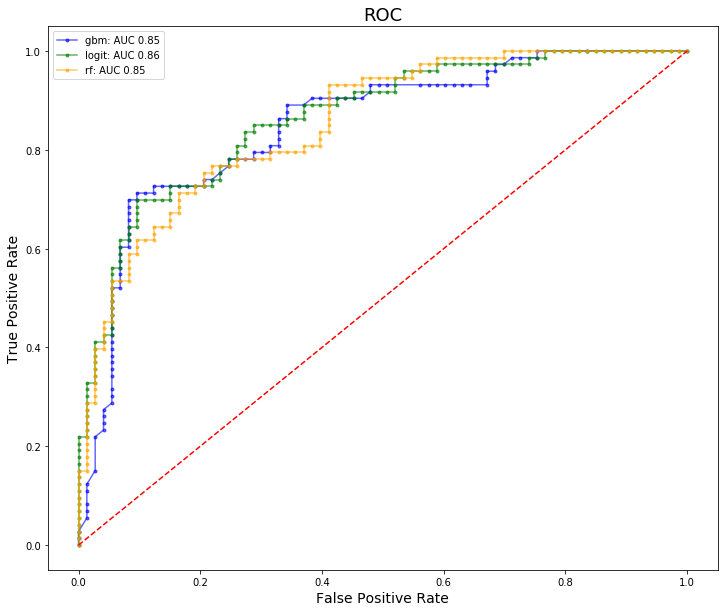

In [34]:
fpr_gbm, tpr_gbm, th_gbm = roc_curve(y_test, gbm_predictions, drop_intermediate=False)
auc_value_gbm = np.round(auc(fpr_gbm, tpr_gbm),2)

fpr_logit, tpr_logit, th_logit = roc_curve(y_test, logit_predictions, drop_intermediate=False)
auc_value_logit = np.round(auc(fpr_logit, tpr_logit),2)

fpr_rf, tpr_rf, th_rf = roc_curve(y_test, rf_predictions, drop_intermediate=False)
auc_value_rf = np.round(auc(fpr_rf, tpr_rf),2)

fig, ax = plt.subplots(figsize=(12,10))
ax.plot(fpr_gbm, tpr_gbm, marker='.', color='blue', alpha=0.6, label='gbm: AUC '+str(auc_value_gbm))
ax.plot(fpr_logit, tpr_logit, marker='.', color='green', alpha=0.6, label='logit: AUC '+str(auc_value_logit))
ax.plot(fpr_rf, tpr_rf, marker='.', color='orange', alpha=0.6, label='rf: AUC '+str(auc_value_rf))
ax.plot(fpr_gbm, fpr_gbm, linestyle='--', color='red')

plt.title("ROC", fontsize=18)
plt.ylabel("True Positive Rate", fontsize=14)
plt.xlabel("False Positive Rate", fontsize=14)
plt.legend()


We can see that the performance of all three models is very similar at the end. What is especially interesting is that the Test AUC for the logit model for this test split is actually higher than the one of the GBM highlighting the need of Cross Validation in model selection.
The actual best average Test-AUC scores from the grid search model selection exercise are:<br/>
**Logistic Regression**: 0.831<br/>
**RF:** 0.827<br/>
**GBM:** 0.832<br/>
(Nevertheless, all three models have very similar performance on this data frame)